# Mean-Variance Optimisation
**Nick Ballingall – 2024**



In [21]:
# Import Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display_html as dhtml

import yfinance as yf
import warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller as adf
from scipy.optimize import minimize

# Suppress numerous yfinance warnings
from warnings import simplefilter
simplefilter(action = "ignore", category = pd.errors.PerformanceWarning)

local_path = 'where/you/saved/csv xlsx files' # Files can be downloaded from sites in REF 1 & 2. Some will need converted to xlsx.


In [41]:
# Import tech-focussed index funds holdings

# Vanguard Information Technology ETF (VGT)
vgt_path = f'{local_path}Holdings_details_Information_Technology_ETF.xlsx'
vgt_raw = pd.read_excel(vgt_path, header = 7)  # row 7 for headers
vgt_rows = vgt_raw.iloc[0:314, :] # Adjusted for new header row
vgt = vgt_rows.loc[:, 'HOLDINGS':'SHARES']
vgt.drop(columns = 'SECURITYDEPOSITORYRECEIPTTYPE', inplace = True)

# SPDR World Technology ETF (WTCH)
wtch_path = f'{local_path}holdings-daily-emea-en-wtch-na.xlsx'
wtch_raw = pd.read_excel(wtch_path, header = 5)
wtch_rows = wtch_raw.iloc[0:169, :]
wtch = wtch_rows.loc[:, 'Security Name':'Base Market Value']
wtch.drop(columns = 'Industry Classification', inplace = True)

# iShares World Information Technology Sector ETF (WITS.L)
wits_path = f'{local_path}iShares-MSCI-World-Information-Technology-Sector-ESG-UCITS-E_fund.xlsx'
wits_raw = pd.read_excel(wits_path, header = 7)
wits_rows = wits_raw.iloc[0:166, :]
wits = wits_rows.loc[:, 'Issuer Ticker':'Market Currency']
wits.drop(columns = ['Notional Value', 'Asset Class'], inplace = True)

wits['Weight (%)'] = wits['Weight (%)']/100 # Correcting % formatting

# Ref 1

In [23]:
# Get top equity holdings market data

# Remove non-USD listings for simplcity
vgt_us = vgt[vgt['COUNTRY'] == 'US']
wits_us = wits[wits['Market Currency'] == 'USD']

# Make ticker list (no significant unique securities in WTCH)
tickers = vgt_us['TICKER'].tolist() + wits_us['Issuer Ticker'].tolist()
tickers = list(set(tickers))

# dfs for stock data
stock_ret = pd.DataFrame()
log_ret = pd.DataFrame()

# 1 year timespan
start_date = '2023-12-01'
end_date = '2024-12-01'

# Download stock data
for ticker in tickers:
    try: # Modified for error handlign with larger dataset
        stock_data = yf.download(
            ticker,
            start = start_date,
            end = end_date,
            interval = '1d', # Daily data
            progress = False # Stop download messages cluttering code
        )
        
        # Check if 'Adj Close' column exists and drop rows with NaN
        if 'Adj Close' not in stock_data.columns or stock_data['Adj Close'].isna().all():
            print(f"Skipping {ticker}: lacking data")
            continue
        
        stock_data.dropna(inplace = True)
        
        # Populate returns df
        stock_data['Returns'] = stock_data['Adj Close'].pct_change()
        stock_ret[ticker] = stock_data['Returns']
        
        # Populate log returns df
        stock_data['Log Returns'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
        log_ret[ticker] = stock_data['Log Returns']
    
    except Exception as e:
        print(f"Error with ticker {ticker}: {e}")

# Drop NaN values (a bit redundant on non-log, but keeping for legibility)
stock_ret.dropna(inplace = True)
log_ret.dropna(inplace = True)


1 Failed download:
['HSBFT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Skipping HSBFT: lacking data


In [25]:
# Run ADF tets to ensure data is stationary

ns_data = [] # non-stationary columns list

# Define portfolio ADF function
def adfTest(data):

    # Run ADF test & track non-stationary data
    for column in data.columns:
        adf_result = adf(data[column])
        
        # Check if the p-value is greater than or equal to 0.05 (non-stationary)
        if adf_result[1] >= 0.05:
            ns_data.append(column)

    # Print the overall status of stationarity
    if len(ns_data) == 0:
        print("All data is stationary.")
    elif len(ns_data) == len(data.columns):
        print("No data is stationary.")
    else:
        print(f"Stocks {', '.join(ns_data)} are not stationary & have been dropped from dataframe.")
        data.drop(columns = ns_data, inplace = True) # Drop non-stationary columns

# Run ADF test
adfTest(log_ret)

# Keep columns in return dfs equal for better comparison 
stock_ret.drop(columns = ns_data, inplace = True)

All data is stationary.


In [35]:
# Calculate risk-free rate

# Use US t-bills yield indices
# 3-month (^IRX), 5-year (^FVX), 10-year (^TNX), 30-year (^TYX)
t_bills = ['^IRX', '^FVX', '^TNX']

# Download T-bill yields
tb_yields = pd.DataFrame()
for t_bill in t_bills:
    tb_data = yf.download(
        t_bill,
        start = start_date,
        end = end_date,
        interval = '1d', # Daily data
        progress = False # Stop download messages cluttering code
    )
    
    tb_yields[t_bill] = tb_data['Adj Close']

# Drop NaN values
tb_yields.dropna(inplace=True)

# Rename columns
tb_yields.rename(columns = {'^IRX': '13-week', '^FVX': '5-year', '^TNX': '10-year'}, inplace = True)

# Create df of weekly rfr
rfr = pd.DataFrame(index = tb_yields.index)

rfr['Short-Term'] = ((1 + tb_yields['13-week'] / 100) ** (1 / 252)) - 1 # 252 trading days per year
rfr['Medium-Term'] = ((1 + tb_yields['5-year'] / 100) ** (1 / 252)) - 1
rfr['Long-Term'] = ((1 + tb_yields['10-year'] / 100) ** (1 / 252)) - 1

# Calculate log rfr for use with log stock returns
for rate in rfr:
    rfr[f'{rate} (log)'] = np.log(1 + rfr[rate])

# Ref 2

In [37]:
# Mean-variance optimisation

# Create function to run on different combinations of stocks & rfrs
def MVO(returns, rfrate):

    # Calculate excess returns
    xs_ret = returns.sub(rfrate, axis = 0)
    
    # Mean and covariance of excess returns
    xsret_mean = xs_ret.mean()
    cov_matrix = xs_ret.cov()
    
    # Define optimization functions
    def pfVol(weights, cov_matrix):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    def negSharpe(weights, xsret_mean, cov_matrix):
        pf_ret = weights @ xsret_mean
        pf_vol = pfVol(weights, cov_matrix)
        return -pf_ret / pf_vol  # Negative Sharpe ratio for minimisation

    # Constraints: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds: Weights between 0 and 40%
    num_stocks = len(returns.columns)
    bounds = tuple((0, 0.4) for _ in range(num_stocks))

    # Initial guess: Equal weights
    initial_weights = np.array([1 / num_stocks] * num_stocks)

    # Optimisation
    result = minimize(
        negSharpe,
        initial_weights,
        args = (xsret_mean, cov_matrix),
        method = 'SLSQP',
        bounds = bounds,
        constraints = constraints
    )

    # Extract results
    optimal_weights = result.x
    optimal_pfret = optimal_weights @ xsret_mean
    optimal_pfvol = pfVol(optimal_weights, cov_matrix)
    optimal_sharpe = optimal_pfret / optimal_pfvol

    # Compile results into a dictionary
    results = {
        'Optimal Weights': pd.Series(optimal_weights, index = returns.columns),
        'Portfolio Return': optimal_pfret,
        'Portfolio Volatility': optimal_pfvol,
        'Sharpe Ratio': optimal_sharpe
    }
    
    return results


# Create function to iterate through stocks & find optimal 5-stock portfolio
def iMVO(returns, rfrate, pf_size, name = 'MVO'):
    remaining_stocks = returns.columns.tolist()
    
    # Dictionary to store the results for each portfolio
    all_results = {}

    while len(remaining_stocks) > pf_size:
        # Run MVO on current set of stocks
        set_ret = returns[remaining_stocks]
        results = MVO(set_ret, rfrate)

        # Store the results of the current portfolio
        all_results[f'{name}_{len(remaining_stocks)} Stocks'] = results

        # Find & remove stock with smallest weight
        sw_stock = results['Optimal Weights'].idxmin()
        remaining_stocks.remove(sw_stock)

    # Final optimisation on the reduced set
    final_returns = returns[remaining_stocks]
    final_results = MVO(final_returns, rfrate)

    # Store the final results for the current portfolio
    all_results[f'{name} Final'] = final_results

    return all_results

# Ref 3

In [39]:
# Run MVO

# Set target portfolio size
pf_size = 5

# Medium-term investment
mt_log = iMVO(log_ret, rfr['Medium-Term (log)'], pf_size, name = 'MT (log)')
mt_reg = iMVO(stock_ret, rfr['Medium-Term'], pf_size, name = 'MT')

#****************
# Using short & long-term rfrs gave no meaningful impact & this code is inneficient.
# Takes 30+ minutes to do all 6

# Short-term investment
#st_log = iMVO(log_ret, rfr['Short-Term (log)'], pf_size, name = 'Short-Term (log)') # Log
#st_reg = iMVO(stock_ret, rfr['Short-Term'], pf_size, name = 'Short-Term (reg)') # Regular

# Long-term investment
#lt_log = iMVO(log_ret, rfr['Long-Term (log)'], pf_size, name = 'Long-Term (log)') # Log
#lt_reg = iMVO(stock_ret, rfr['Long-Term'], pf_size, name = 'Long-Term (reg)') # Regular


In [45]:
# Print MVO Results

# Medium-term investment
print("Optimised Portfolio")
print(f"\nLog Returns:\n{mt_log['MT (log) Final']}")
print(f"\nRegular Returns:\n{mt_reg['MT Final']}")


#**************************
# Hidden (see cell above)

# Short-term
#print("Short-Term Investment:")
#print(f"\nLog Returns:\n{st_log['Short-Term (log) Final']}") # Log
#print(f"\nReturns:\n{st_reg['Short-Term (reg) Final']}") # Reg

#print(f"\n*****************")

# Long-term
#print("\nLong-Term Investment")
#print(f"\nLog Returns:\n{lt_log['Long-Term (log) Final']}")
#print(f"\nReturns:\n{lt_reg['Long-Term (reg) Final']}")


Optimised Portfolio

Log Returns:
{'Optimal Weights': JNPR    0.143157
IDCC    0.173460
GDDY    0.269303
MSI     0.271883
ENV     0.142197
dtype: float64, 'Portfolio Return': 0.0019382252014563306, 'Portfolio Volatility': 0.007893062242594824, 'Sharpe Ratio': 0.24556061283752706}

Regular Returns:
{'Optimal Weights': IDCC    0.164715
GDDY    0.311245
MSI     0.239798
GLW     0.138701
ENV     0.145541
dtype: float64, 'Portfolio Return': 0.002199654804439152, 'Portfolio Volatility': 0.008543268687183933, 'Sharpe Ratio': 0.25747227261375194}


In [55]:
# Annualise results

def anRes(results, freq = 252): # 252 trading days per year
    
    # Extract values from MVO results
    pf_ret = results['Portfolio Return']
    pf_vol = results['Portfolio Volatility']

    # Daily > annual return & volatility
    an_ret = pf_ret * freq
    an_vol = pf_vol * np.sqrt(freq)

    # Weekly > annual Sharpe ratio
    an_sharpe = an_ret / an_vol

    # Store values in dictionary
    an_vals = {
        'Return': an_ret,
        'Volatility': an_vol,
        'Sharpe Ratio': an_sharpe
    }

    return an_vals

# Medium-term

# Annualise log returns
an_mtlog = anRes(mt_log['MT (log) Final'])
print(f"\nAnnualised Log Returns:\n{an_mtlog}")

# Annualise regular returns
an_mtreg = anRes(mt_reg['MT Final'])
print(f"\nAnnualised Regular Returns:\n{an_mtreg}")

#**************************
# Short-term
#print("Short-Term Investment:")

# Annualise log returns
#an_stlog = anRes(st_log['Short-Term (log) Final'])
#print(f"\nAnnualised Log Returns:\n{an_stlog}")

# Annualise regular returns
#an_streg = anRes(st_reg['Short-Term (reg) Final'])
#print(f"\nAnnualised Regular Returns:\n{an_streg}")

#print(f"\n*****************")

# Long-term
#print("\nLong-Term Investment")

# Annualise log returns
#an_ltlog = anRes(lt_log['Long-Term (log) Final'])
#print(f"\nAnnualised Log Returns:\n{an_ltlog}")

# Annualise regular returns
#an_ltreg = anRes(lt_reg['Long-Term (reg) Final'])
#print(f"\nAnnualised Regular Returns:\n{an_ltreg}")



Annualised Log Returns:
{'Return': 0.4884327507669953, 'Volatility': 0.12529847865995805, 'Sharpe Ratio': 3.898153880164269}

Annualised Regular Returns:
{'Return': 0.5543130107186663, 'Volatility': 0.13562018597936373, 'Sharpe Ratio': 4.087245616983683}


In [93]:
# Extract lists from dictionaries
# Dictionaries were cuasing some issues below

# Extract the dictionary
log_tw = mt_log['MT (log) Final']
reg_tw = mt_reg['MT Final']

# Extract tickers & weights
log_tw = log_tw['Optimal Weights']
reg_tw = reg_tw['Optimal Weights']

# Create seperate lists
log_tickers = log_tw.index.tolist()
log_weights = log_tw.values.tolist()

reg_tickers = reg_tw.index.tolist()
reg_weights = reg_tw.values.tolist()

# Output the lists
print(f'Log Returns \
    \nTickers: {log_tickers} \
    \nWeights: {log_weights}')

print(f'\nRegular Returns \
    \nTickers: {reg_tickers} \
    \nWeights: {reg_weights}')


Log Returns     
Tickers: ['JNPR', 'IDCC', 'GDDY', 'MSI', 'ENV']     
Weights: [0.14315690405286408, 0.17345954749803386, 0.2693034302522686, 0.2718830003076758, 0.14219711788915765]

Regular Returns     
Tickers: ['IDCC', 'GDDY', 'MSI', 'GLW', 'ENV']     
Weights: [0.16471450032739135, 0.31124521388030046, 0.2397979436511829, 0.13870146835669256, 0.1455408737844326]


In [139]:
# Dataframes for optimised portfolios

# Create df copies
log_pf = log_ret[log_tickers].copy()
reg_pf = stock_ret[reg_tickers].copy()

# Dataframes for portfolio & index returns
log_pf.loc[:, 'Portfolio (log)'] = log_pf[log_tickers].dot(log_weights)  # Log
reg_pf.loc[:, 'Portfolio'] = reg_pf[reg_tickers].dot(reg_weights)  # Regular


# Dataframes for funds returns

# Create Lists
# Tickers
vgt_tickers = vgt_us['TICKER'].tolist()
vgt_tickers = [ticker for ticker in vgt_tickers if ticker in log_ret.columns]  # Filter tickers

wits_tickers = wits_us['Issuer Ticker'].tolist()
wits_tickers = [ticker for ticker in wits_tickers if ticker in log_ret.columns]  # Filter tickers

# Fund Weights
vgt_weights = vgt_us['% OF FUNDS*'].tolist()
vgt_weights = [vgt_weights[i] for i, ticker in enumerate(vgt_tickers) if ticker in log_ret.columns]  # Align weights with tickers

# Convert string values to numeric
def toNum(i):
    if i == '<0.01%':
        return 0.0001  # Smallest value
    else:
        return float(i) #.replace('%', '').replace('<', '')) / 100

# Apply function
vgt_weights = np.array([toNum(weight) for weight in vgt_weights])

wits_weights = wits_us['Weight (%)'].tolist()
wits_weights = [wits_weights[i] for i, ticker in enumerate(wits_tickers) if ticker in log_ret.columns]  # Align weights with tickers
wits_weights = [w / 100 for w in wits_weights] # correct % formatting

In [141]:
# Create dataframe of portfolio & fund excess returns

# Log returns
xsr_log = pd.DataFrame()

xsr_log['Portfolio'] = log_pf['Portfolio (log)'] # Portfolio
xsr_log['VGT'] = log_ret[vgt_tickers].dot(vgt_weights) # VGT
xsr_log['WITS'] = log_ret[wits_tickers].dot(wits_weights) # WITS

# Log returns
xsr = pd.DataFrame()

xsr['Portfolio'] = reg_pf['Portfolio'] # Portfolio
xsr['VGT'] = stock_ret[vgt_tickers].dot(vgt_weights) # VGT
xsr['WITS'] = stock_ret[wits_tickers].dot(wits_weights) # WITS

Correlation Matrix (Log Returns):
                     JNPR      IDCC      GDDY       MSI       ENV  \
JNPR             1.000000  0.030274  0.115476  0.028485  0.013962   
IDCC             0.030274  1.000000  0.082621  0.201049  0.177868   
GDDY             0.115476  0.082621  1.000000  0.316905  0.112109   
MSI              0.028485  0.201049  0.316905  1.000000  0.023033   
ENV              0.013962  0.177868  0.112109  0.023033  1.000000   
Portfolio (log)  0.333391  0.561987  0.695857  0.619407  0.436574   

                 Portfolio (log)  
JNPR                    0.333391  
IDCC                    0.561987  
GDDY                    0.695857  
MSI                     0.619407  
ENV                     0.436574  
Portfolio (log)         1.000000  

Correlation Matrix (Regular Returns):
               IDCC      GDDY       MSI       GLW       ENV  Portfolio
IDCC       1.000000  0.078427  0.198772  0.230407  0.170643   0.559762
GDDY       0.078427  1.000000  0.313909  0.051998  0.112

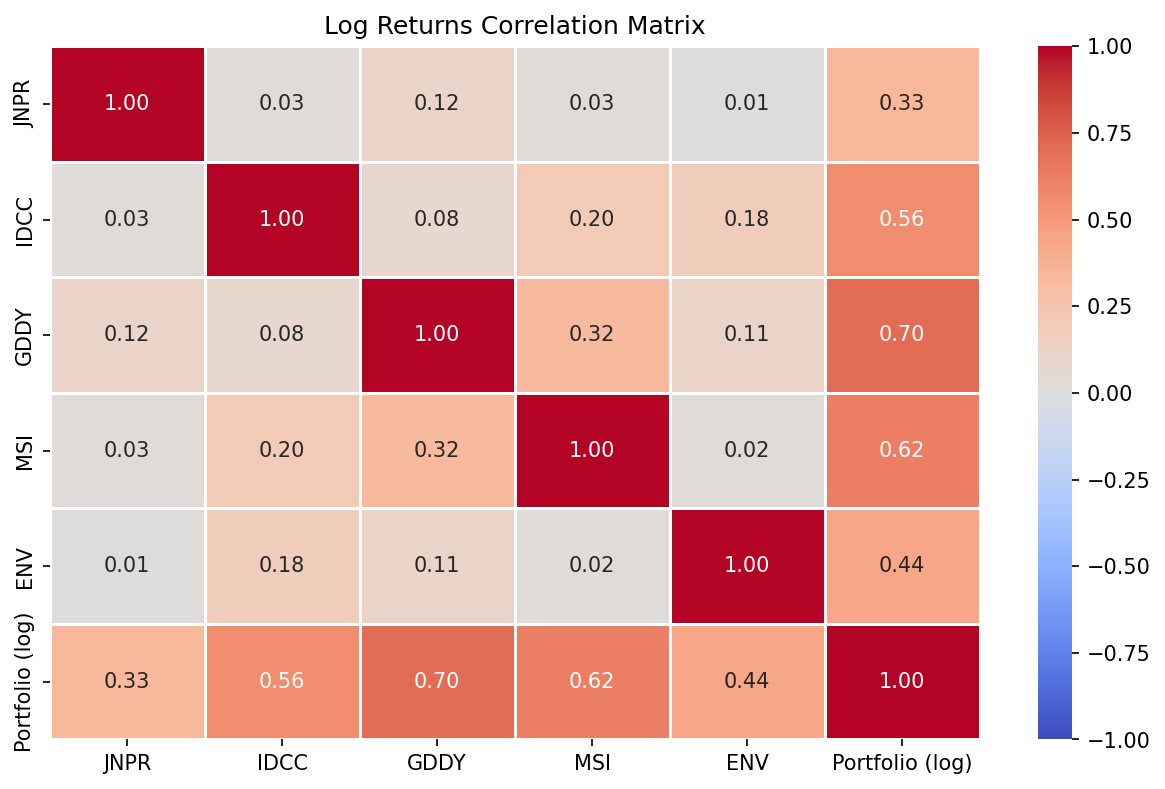

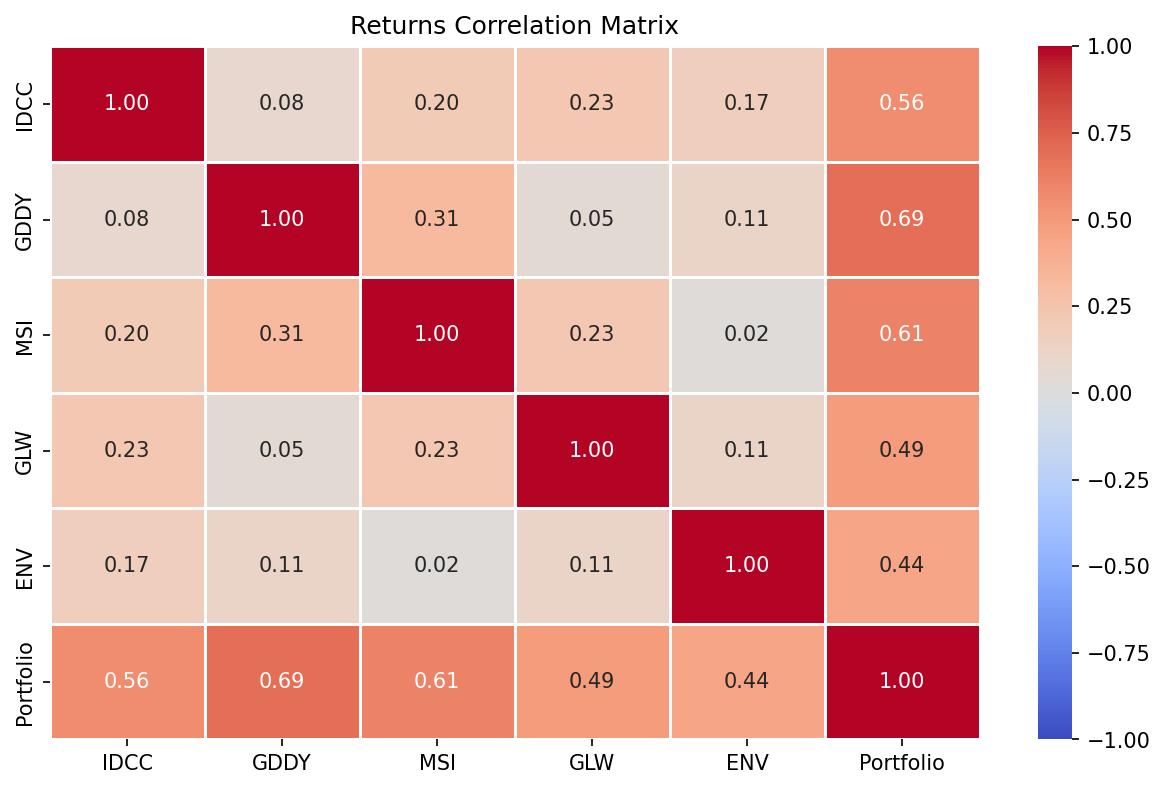

In [143]:
# Correlation matrix

cmx_log = log_pf.corr() # Log
cmx_reg = reg_pf.corr() # Regular

# Display correlation matrix
print("Correlation Matrix (Log Returns):")
print(cmx_log)

print("\nCorrelation Matrix (Regular Returns):")
print(cmx_reg)

# CMX heatmaps

# Log
plt.figure(figsize = (10, 6), dpi = 150)
sns.heatmap(cmx_log, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, fmt = '.2f', linewidths = 0.5)
plt.title('Log Returns Correlation Matrix')
plt.savefig('Log Returns Heat Map.png')
plt.show()

# Regular
plt.figure(figsize = (10, 6), dpi = 150)
sns.heatmap(cmx_reg, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, fmt = '.2f', linewidths = 0.5)
plt.title('Returns Correlation Matrix')
plt.savefig('Regular Returns Heat Map.png')
plt.show()


/var/folders/05/gww8vx014vx4j1fbdxvrjm100000gn/T/ipykernel_58450/594583702.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colours, len(weights))


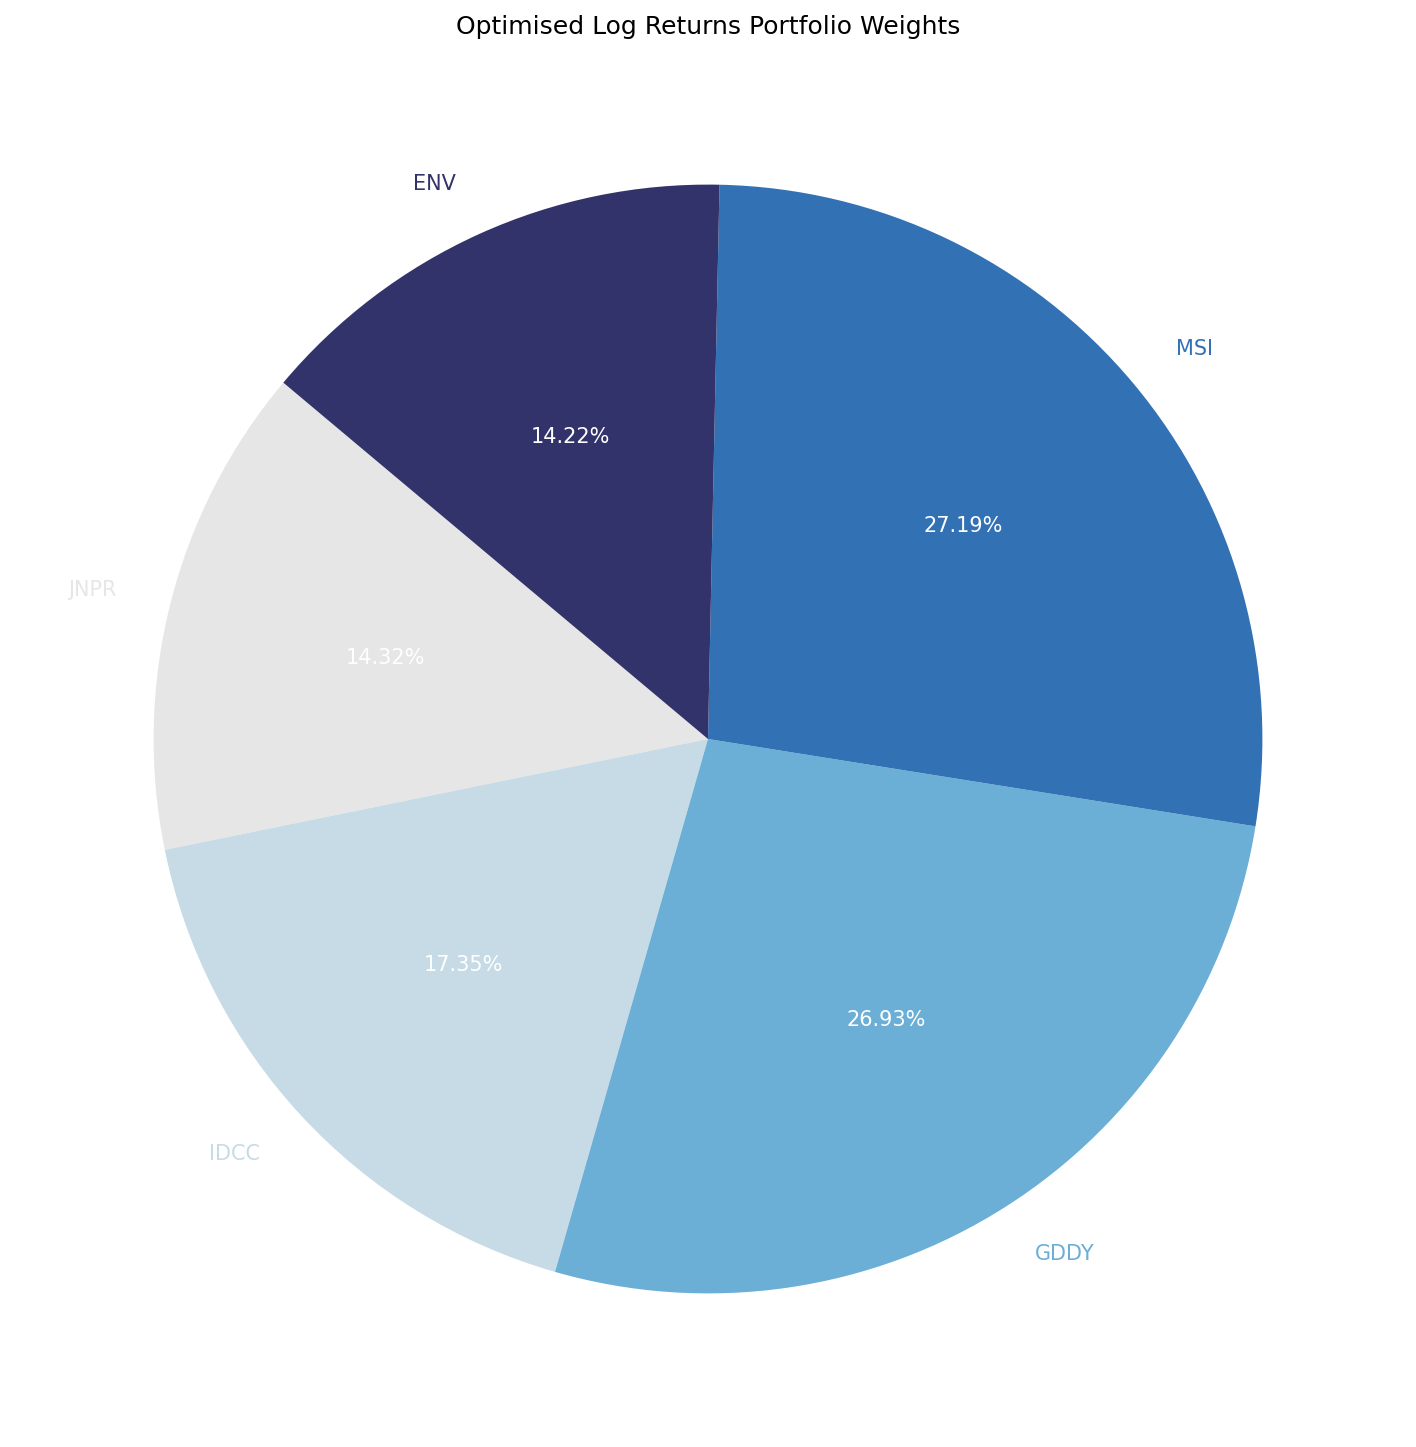

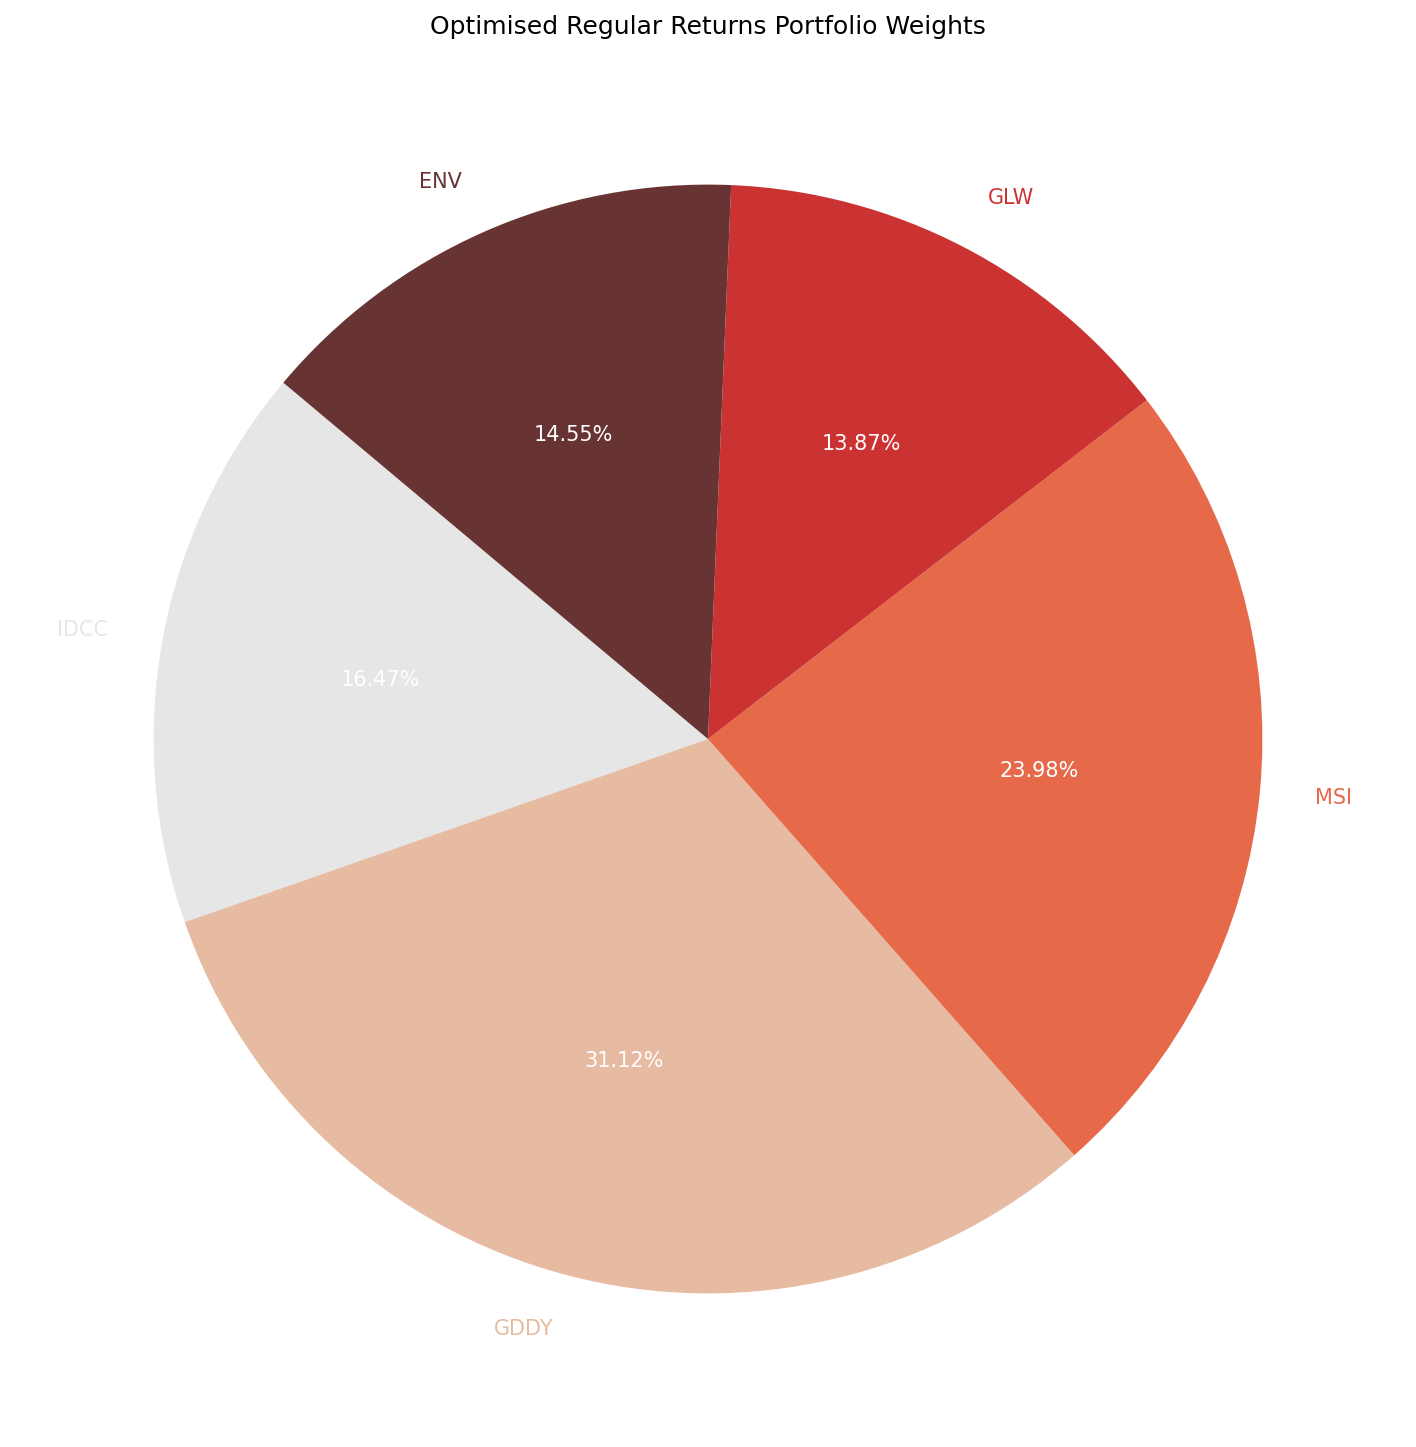

In [145]:
# Visualise portfolio breakdowns

# Define function for visual uniformity
def pieChart(title, weights, tickers, colours):

    # Colour map
    cmap = cm.get_cmap(colours, len(weights))
    fill = [cmap(i) for i in range(len(weights))]

    # Limit black/white values
    max_int = 0.9
    min_int = 0.2
    
    constrained_fill = []
    for colour in fill:
        # Adjust RGB vals
        r, g, b, a = colour
        r = max(min(r, max_int), min_int)
        g = max(min(g, max_int), min_int)
        b = max(min(b, max_int), min_int)
        constrained_fill.append((r, g, b, a))

    # Pie Chart
    plt.figure(figsize = (12, 12), dpi = 150)
    wedges, texts, autotexts = plt.pie(
        weights,
        labels = tickers,
        autopct = '%1.2f%%',
        startangle = 140,
        colors = constrained_fill
    )
    
    plt.title(f'{title} Weights')

    # Coloured lables
    for text, colour in zip(texts, constrained_fill):
        text.set_color(colour)
        
    # Coloured % lables
    for autotext in autotexts:
        autotext.set_color('white')

    plt.savefig(f'{title} Weights.png')
    plt.show()

# Create charts
pieChart('Optimised Log Returns Portfolio', log_weights, log_tickers, 'Blues') # Log
pieChart('Optimised Regular Returns Portfolio', reg_weights, reg_tickers, 'Reds') # Regular


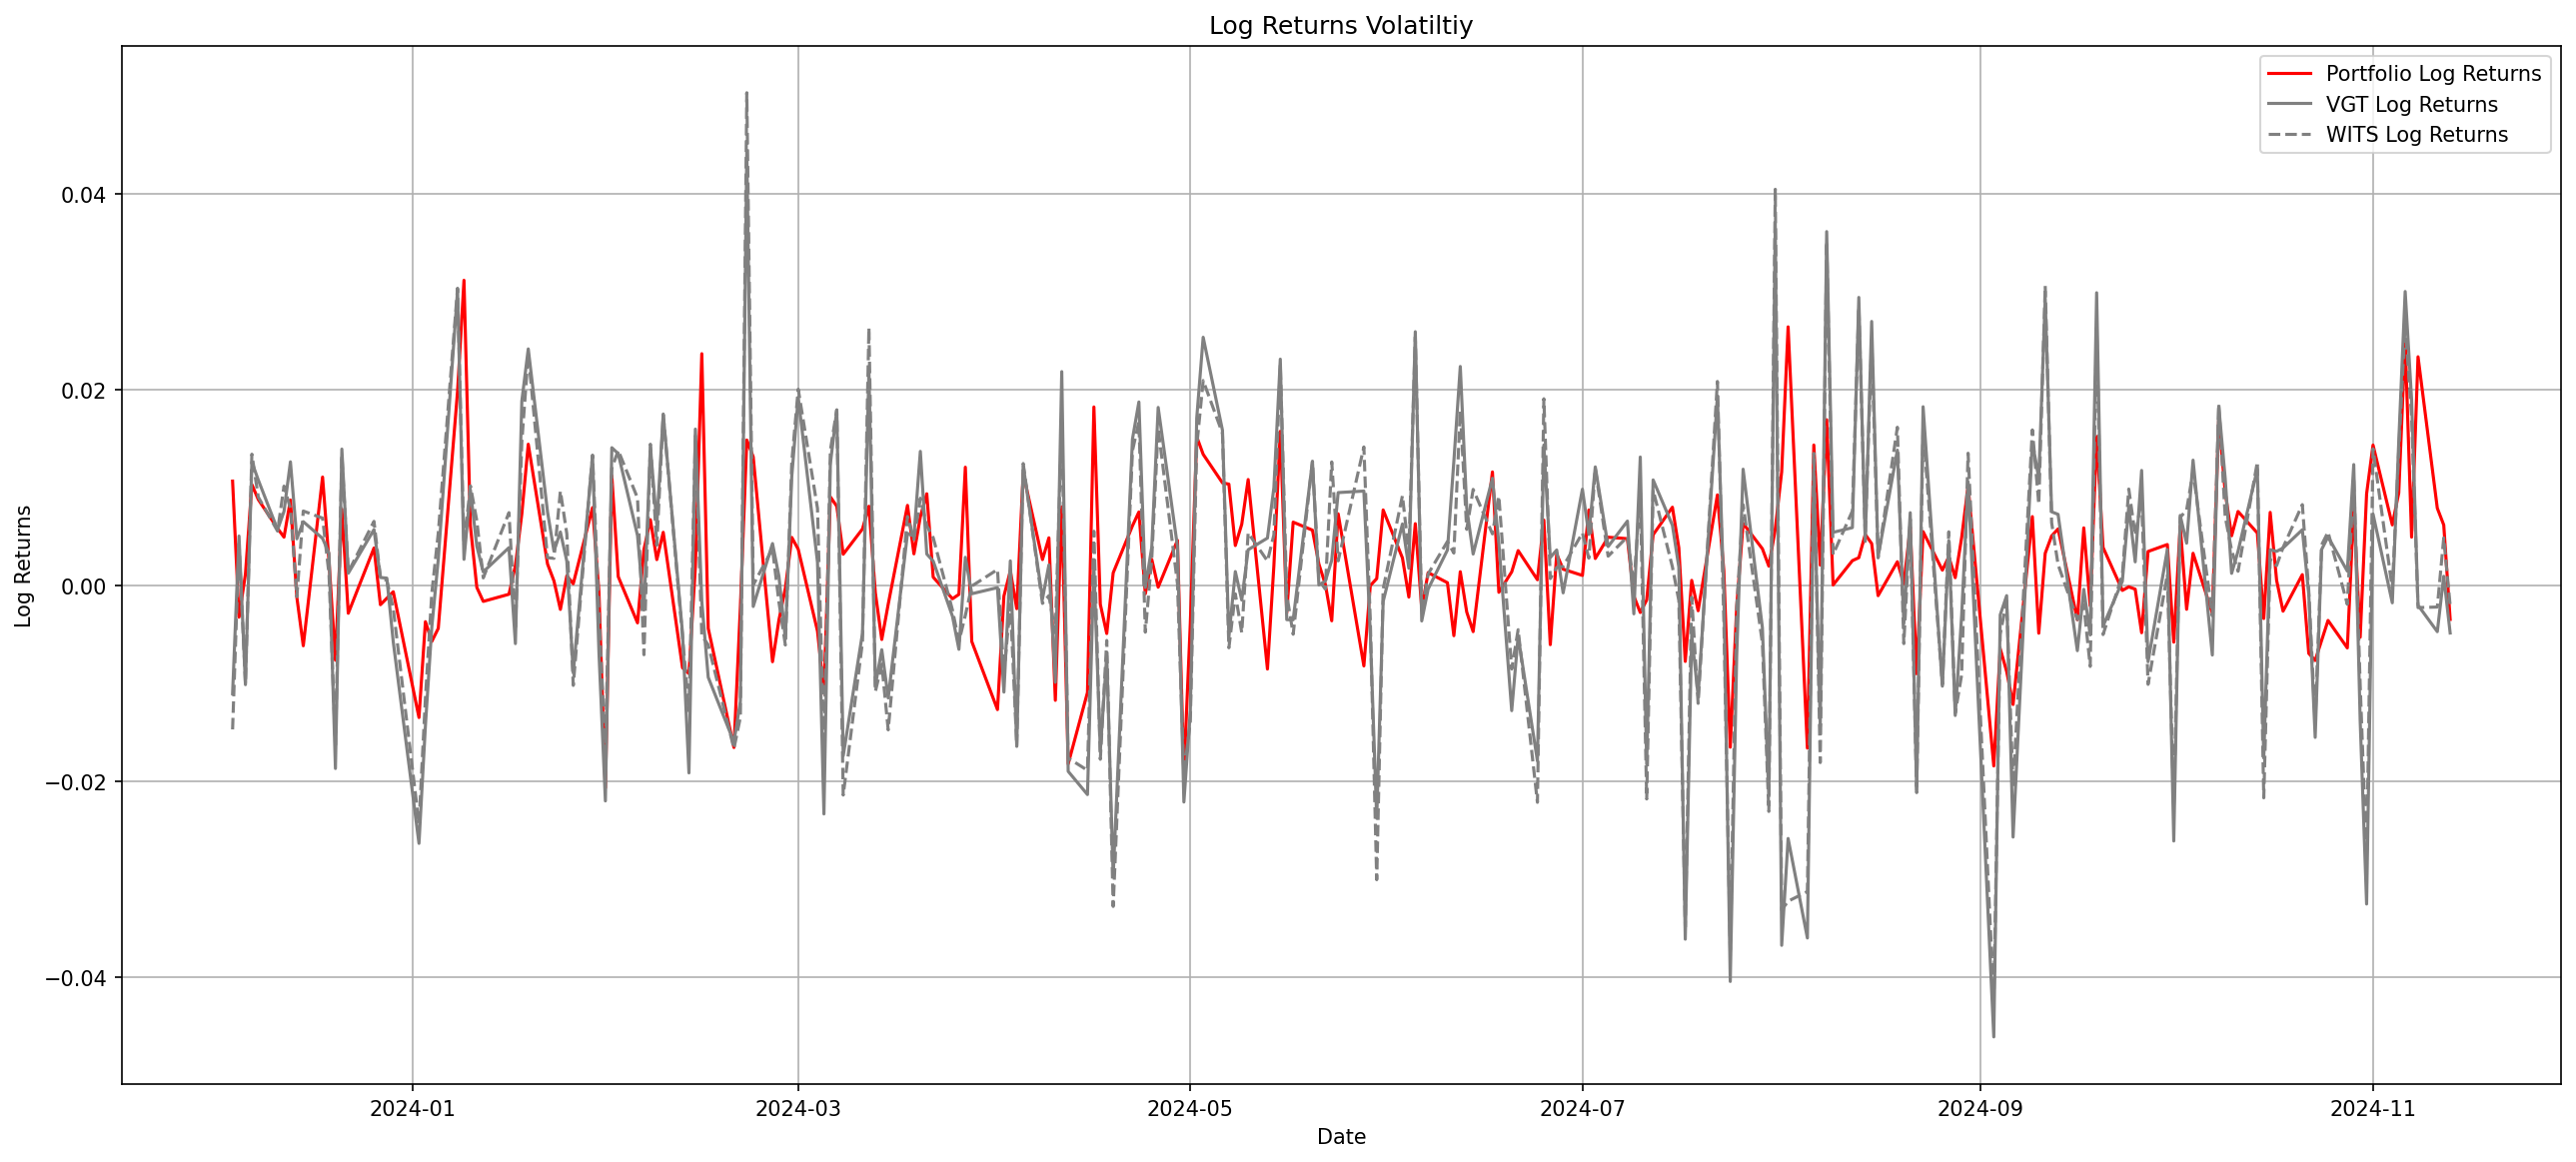

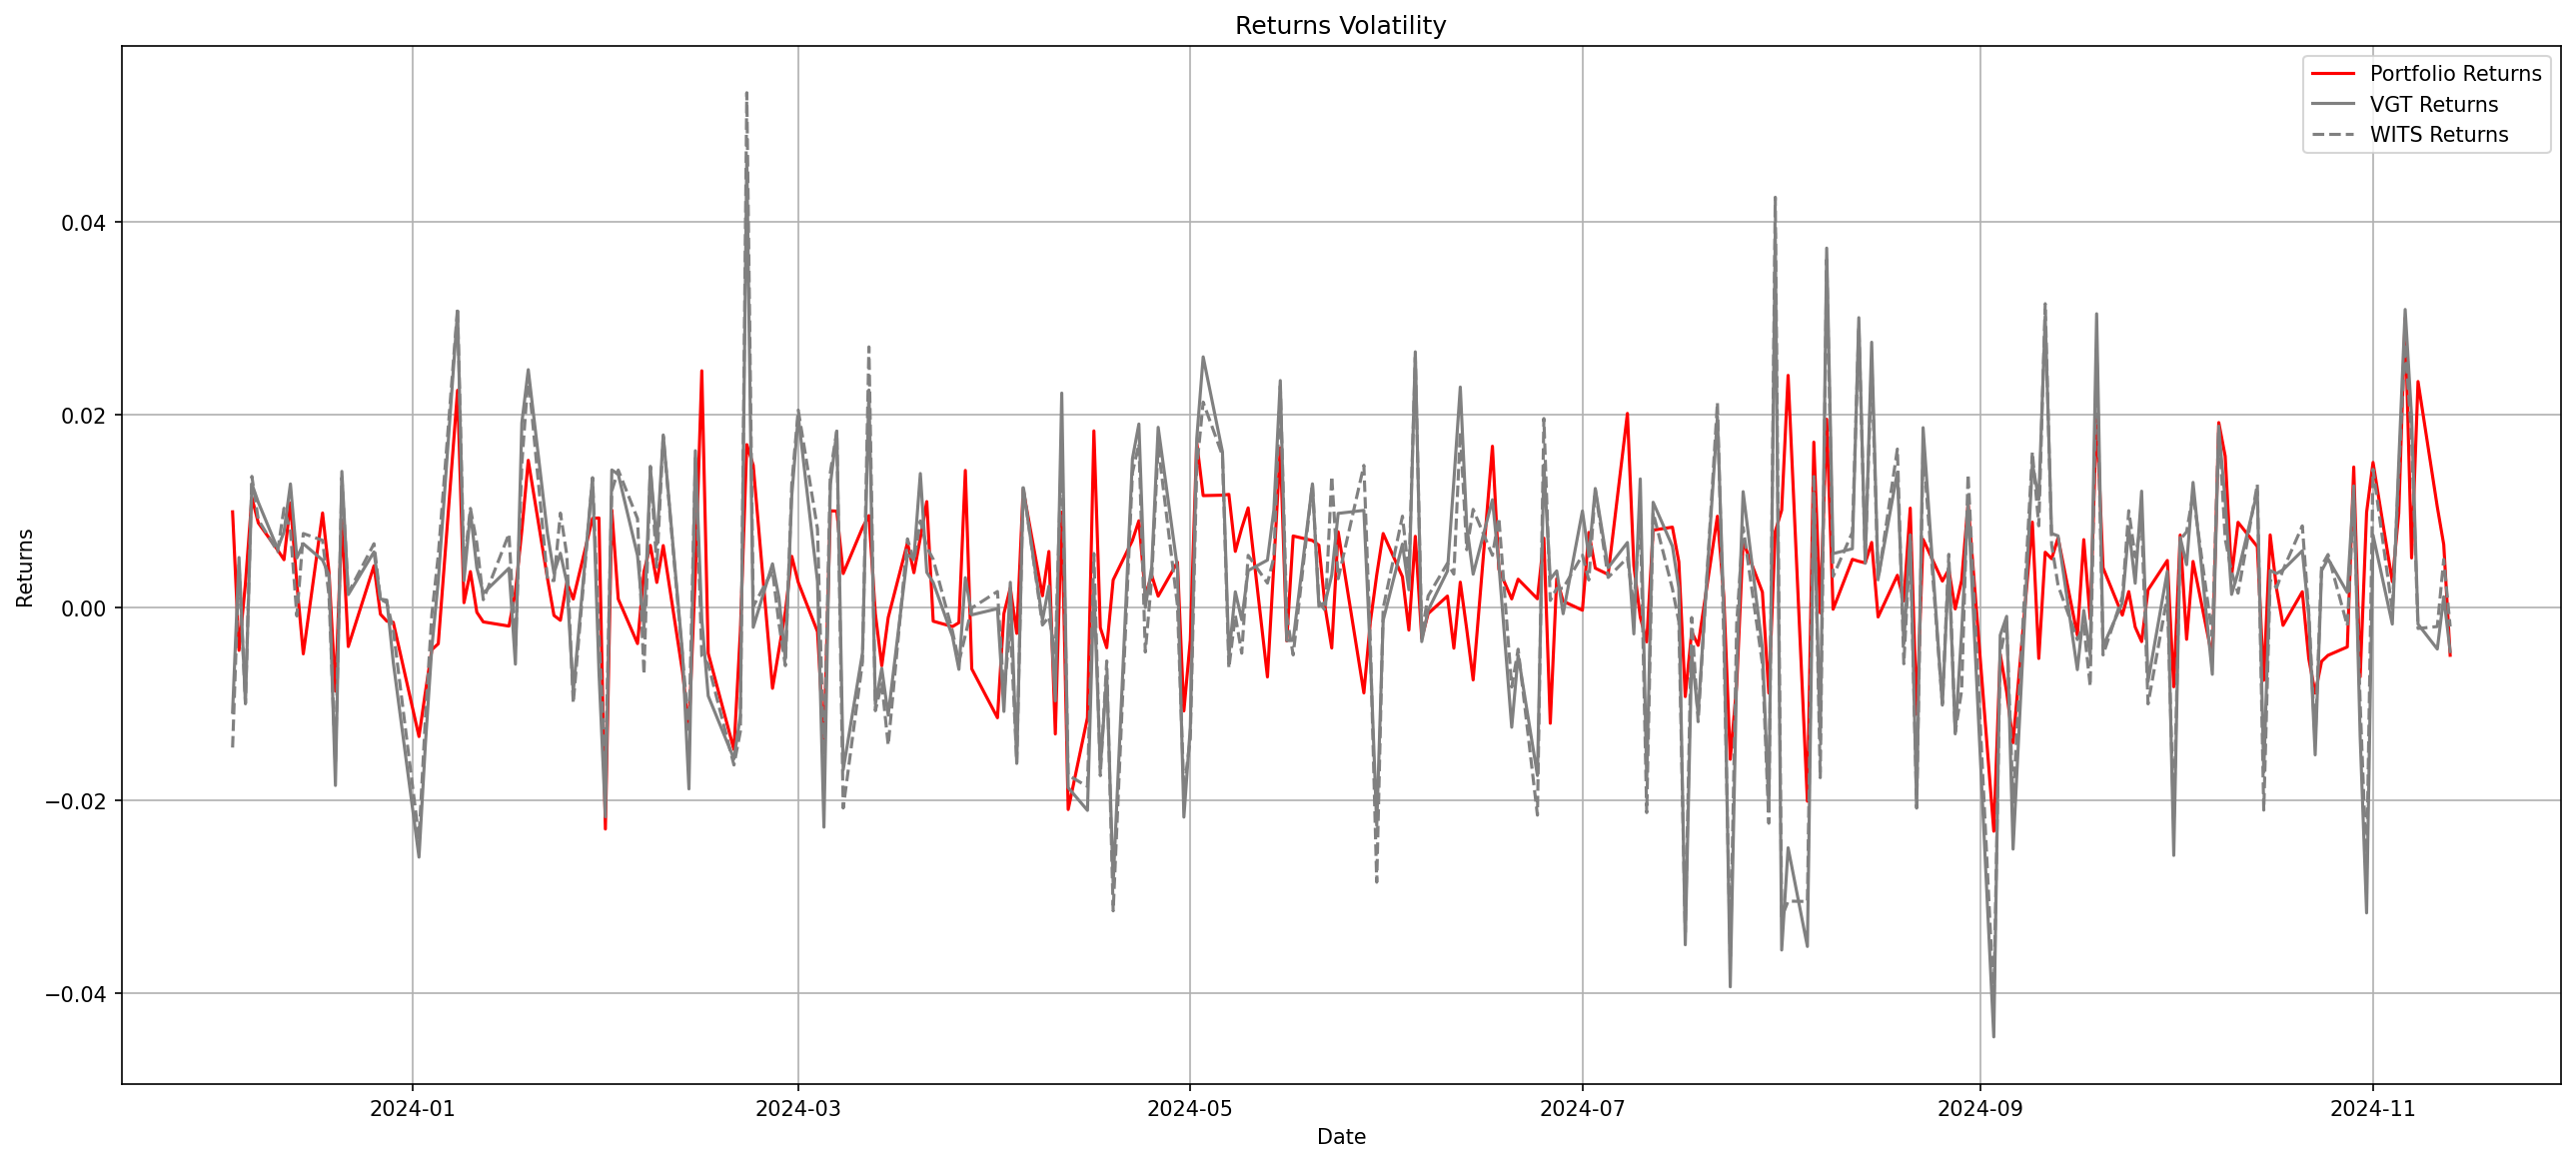

In [153]:
# Plot portfolio vs. funds excess returns

# Log returns

# Create plot
plt.figure(figsize = (21, 9), dpi = 150)

plt.plot( # Portfolio
    xsr_log.index, 
    xsr_log['Portfolio'], 
    label = 'Portfolio Log Returns',
    linestyle = '-',
    color = 'Red')

plt.plot( # VGT
    xsr_log.index, 
    xsr_log['VGT'], 
    label = 'VGT Log Returns',
    linestyle = '-',
    color = 'Grey')

plt.plot( # WITS
    xsr_log.index, 
    xsr_log['WITS'], 
    label = 'WITS Log Returns',
    linestyle = '--',
    color = 'Grey')

# Add plot details
plt.title("Log Returns Volatiltiy")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.grid(True)

plt.savefig('Volatility (log).png')

# Show plot
plt.show()

#***************

# Regular returns

# Create plot
plt.figure(figsize = (21, 9), dpi = 150)

plt.plot( # Portfolio
    xsr.index, 
    xsr['Portfolio'], 
    label = 'Portfolio Returns',
    linestyle = '-',
    color = 'Red')

plt.plot( # VGT
    xsr.index, 
    xsr['VGT'], 
    label = 'VGT Returns',
    linestyle = '-',
    color = 'Grey')

plt.plot( # WITS
    xsr.index, 
    xsr['WITS'], 
    label = 'WITS Returns',
    linestyle = '--',
    color = 'Grey')

# Add plot details
plt.title("Returns Volatility")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)

plt.savefig('Volatility (reg).png')

# Show plot
plt.show()

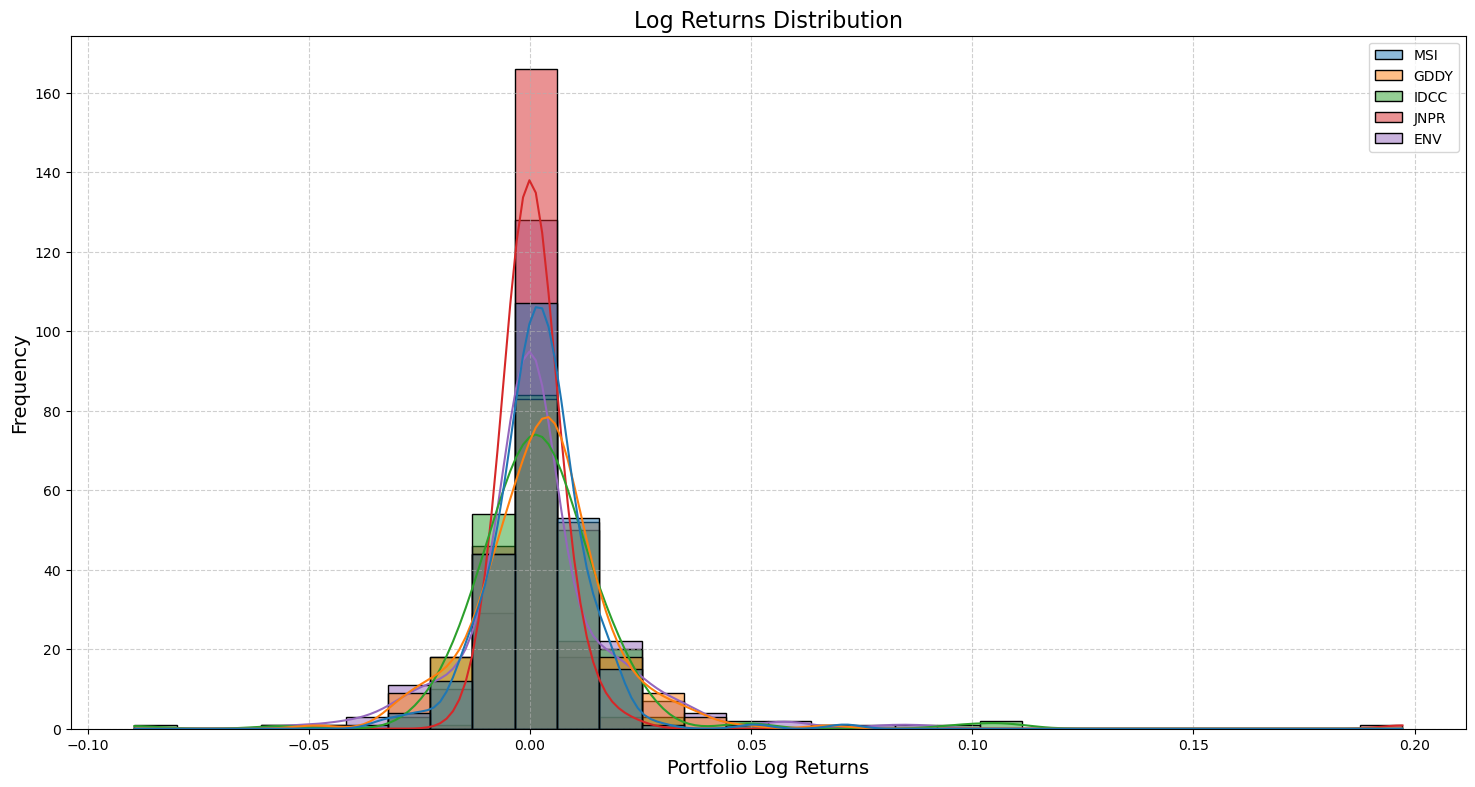

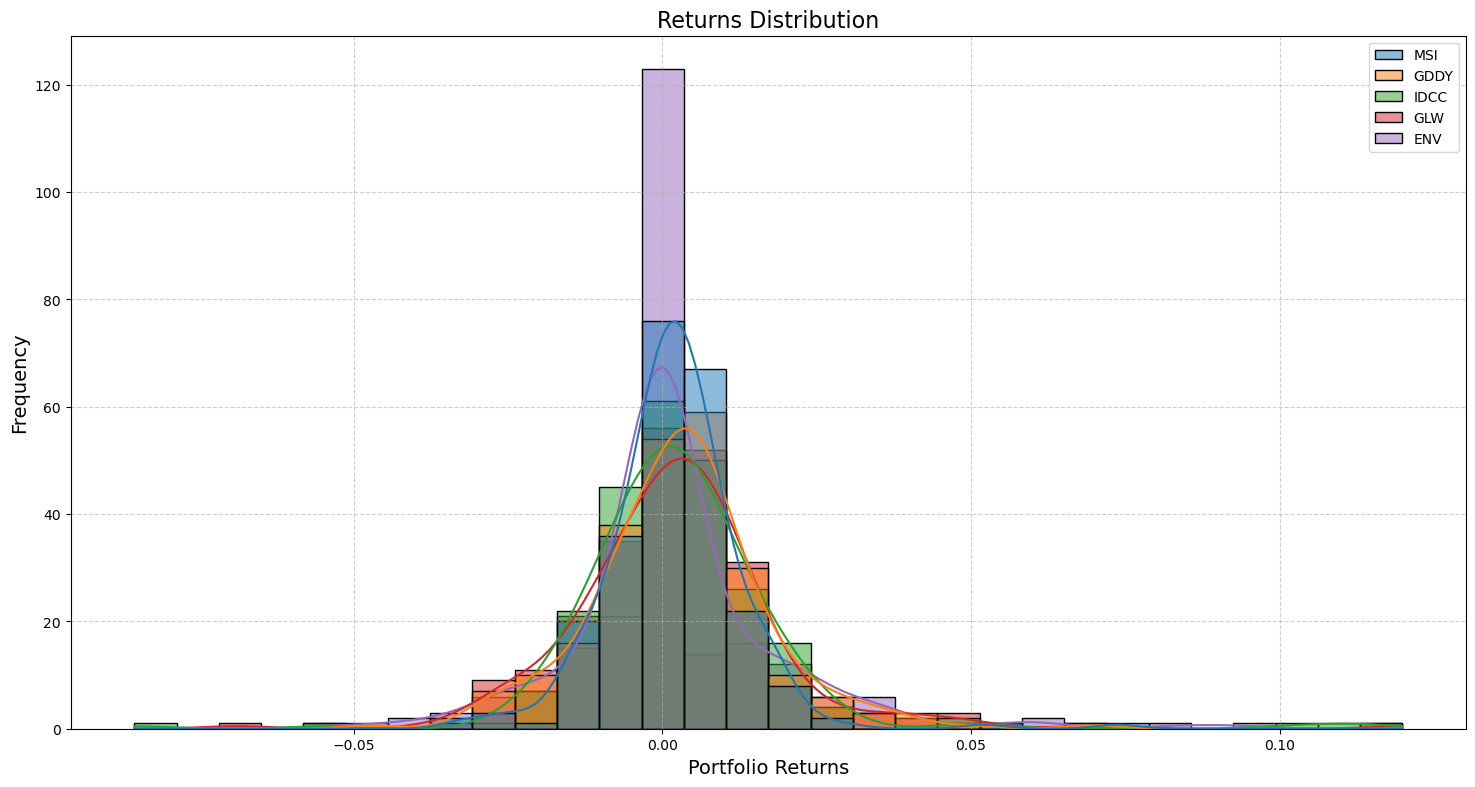

In [177]:
# Return Distribution

# Log
plt.figure(figsize=(18, 9))

# Histogram & KDE
sns.histplot(log_pf[['MSI', 'GDDY', 'IDCC', 'JNPR', 'ENV']], kde = True, bins = 30, color='blue', edgecolor = 'black')

# Add labels and title
plt.title("Log Returns Distribution", fontsize = 16)
plt.xlabel("Portfolio Log Returns", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('Log Returns Dist.png')
plt.show()



# Regular
plt.figure(figsize=(18, 9))

# Histogram & KDE
sns.histplot(reg_pf[['MSI', 'GDDY', 'IDCC', 'GLW', 'ENV']], kde = True, bins = 30, color='red', edgecolor = 'black')

# Add labels and title
plt.title("Returns Distribution", fontsize = 16)
plt.xlabel("Portfolio Returns", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('Returns Dist.png')
plt.show()


In [155]:
# Fama-French 5 Factor Model
# Set-up

# Fetch the FF5 data set csv
ff_factors = pd.read_csv(f'{local_path}FF5-Daily.csv', skiprows=3)

# Formatting the dataframe
ff_factors.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'] # Don't need RF when using xsr df

# Clean the FF factors data
ff_factors = ff_factors.dropna(subset=['Date'])
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m%d')

# Convert 'Date' column to datetime
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format = '%Y%m%d')

# Set 'Date' as the index
ff_factors.set_index('Date', inplace = True)

# FF5 function
def ffModel(df, col): # df & column of excess returns
    
    # Merge FF factors with portfolio returns
    combined_data = pd.merge(df[col], ff_factors, left_index = True, right_index = True)
    
    # Define the independent variables (factors) and dependent variable (excess returns)
    X = combined_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    y = combined_data[col]
    
    # Add a constant term for the intercept in the regression model
    X = sm.add_constant(X)
    
    # Run the regression (Ordinary Least Squares - OLS)
    model = sm.OLS(y, X).fit()

    # Regression highlights
    def olsSummary(model):

        print(model.summary())
        print(f'\n### OLS Regression Highlights ###') # Title/seperator
        
        # Key metrics
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        f_statistic = model.fvalue
        p_value = model.f_pvalue
        coef_summary = model.summary2().tables[1]  # Get coefficient summary
        
        # Extract important coefficients and p-values
        const_coef = coef_summary.loc['const', 'Coef.']
        const_pval = coef_summary.loc['const', 'P>|t|']
        mkt_rf_coef = coef_summary.loc['Mkt-RF', 'Coef.']
        mkt_rf_pval = coef_summary.loc['Mkt-RF', 'P>|t|']
        
        # Print key metrics
        print(f"\n1. R-squared: {r_squared:.3f} (Explains {r_squared * 100:.2f}% of the variance in excess returns)")
        
        print(f"\n2. Adjusted R-squared: {adj_r_squared:.3f}")
       
        print(f"\n3. F-statistic: {f_statistic:.3f} (p-value: {p_value:.3f}) - Overall model significance")
        
        # Coefficient interpretation
        print(f"\n4. Constant term (Intercept): {const_coef:.6f} (p-value: {const_pval:.3f}) - Represents the expected excess return when all factors are zero.")
        
        print(f"\n5. Market Risk Premium (Mkt-RF): {mkt_rf_coef:.6f} (p-value: {mkt_rf_pval:.3f}) - Indicates the expected change in excess returns for a 1% increase in market risk premium.")

    # Run olsSummary
    olsSummary(model)

# Ref 4

In [161]:
# Apply FF5 model

# Only on xsr, as FF5 isn't built around lgo returns
print('Portfolio #######')
ffModel(xsr, 'Portfolio')

print(f'\n**********************')

# Apply FF5 to individual portfolio stocks
for ticker in reg_tickers:
    
    print(f'\n{ticker} #######')
    ffModel(reg_pf, ticker)
    
    print(f'\n**********************')


Portfolio #######
                            OLS Regression Results                            
Dep. Variable:              Portfolio   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     35.98
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           5.80e-27
Time:                        04:08:24   Log-Likelihood:                 843.98
No. Observations:                 230   AIC:                            -1676.
Df Residuals:                     224   BIC:                            -1655.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000  

## Data References
**Ref 1:**

https://advisors.vanguard.com/investments/products/vgt/vanguard-information-technology-etf#portfolio

https://www.ishares.com/uk/individual/en/products/308858/ishares-msci-world-information-technology-sector-esg-ucits-etf

https://www.ssga.com/uk/en_gb/investor/prospectuses-etf-information

https://digital.fidelity.com/prgw/digital/research/quote/dashboard/summary?symbol=FTEC

**Ref 2:**

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html